<a href="https://colab.research.google.com/github/ElvisRojasM/Construction-of-Socioeconomic-Indicators-Using-Python/blob/main/6_Scraping_del_SBS_y_regresion_panel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scraping del SBS y regresion panel para prestamos

**Descripción Técnica del Proyecto: Evaluación de la Relación entre PBI y Finanzas mediante Modelos Panel**

1. **Extracción de Datos**:
   - Se extraen datos de series de tiempo desde la página de la Superintendencia de Banca, Seguros y AFP (SBS) en Perú, utilizando rutas específicas para cada año y mes.

2. **Limpieza de Datos**:
   - Se renombran y reorganizan las columnas para asegurar consistencia en los nombres de las variables.
   - Se eliminan filas con valores faltantes y duplicados.
   - Se uniformizan los nombres de distritos y departamentos eliminando espacios en blanco y acentos.
   - Se completan las celdas vacías utilizando el método de "forward fill".

3. **Transformación de Datos**:
   - Se crean columnas de fecha y año para facilitar la manipulación temporal de los datos.
   - Se reemplazan valores "-" con ceros y se convierten las columnas numéricas a tipo `float`.

4. **Selección de Variables**:
   - Se filtran las columnas relevantes: 'departamento', 'year', 'date', 'distrito', 'provincia', 'depositos totales total' y 'creditos directos total'.
   - Se define la variable dependiente (PBI) y las variables independientes (depósitos y créditos).

5. **Modelo de Regresión de Panel**:
   - Se añaden efectos de entidad y de tiempo para controlar variaciones específicas.
   - Se ajusta el modelo PanelOLS con las variables dependientes e independientes seleccionadas.

6. **Análisis y Visualización**:
   - Se generan gráficos para visualizar las series de tiempo y las relaciones identificadas.
   - Se imprimen los resultados de las regresiones para interpretar las relaciones económicas entre el PBI y las variables financieras.


In [ ]:
import pandas as pd
import numpy as np
import calendar

import matplotlib.pyplot as plt
import matplotlib.dates as mdates   #v 3.3.2  ###

In [ ]:
pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from unidecode import unidecode

Infomacion de la base de datos de la SBS:

* Banca Multiple: Créditos Directos y Depósitos por Zona Geográfica : Datos desde 1998
* Cajas Rurales: Créditos Directos y Depósitos por Zona Geográfica : Datos desde 2001
* Cajas Municipales: Créditos Directos y Depósitos por Zona Geográfica : Datos desde 2001
* Empresas de Créditos: Créditos Directos por Zona Geográfica : Datos desde 2001
* Empresas Financieras: Créditos Directos y Depósitos por Zona Geográfica : Datos desde 2015

## Ejemplo de limpieza de datos para enero del anio 2002

In [ ]:
## Importamos datos desde enero del 2002:
import urllib.error

url = "https://intranet2.sbs.gob.pe/estadistica/financiera/2002/Enero/B-2314-en2002.XLS"

try:
    df_raw = pd.read_excel(url, skiprows=5, skipfooter = 3)
except urllib.error.URLError as e:
    print("Error al acceder a la URL:", e)


In [ ]:
df = df_raw.copy()
df

,Departamento,Créditos Directos,Unnamed: 2,Unnamed: 3,Depósitos a la Vista,Unnamed: 5,Unnamed: 6,Depósitos de Ahorro,Unnamed: 8,Unnamed: 9,Depósitos a Plazo,Unnamed: 11,Unnamed: 12,Depósitos Totales,Unnamed: 14,Unnamed: 15
0,NaN,MN,ME,Total,MN,ME,Total,MN,ME,Total,MN,ME,Total,MN,ME,Total
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Amazonas,2493,3255,5748,2940,551,3491,14513,13451,27964,217,1670,1887,17670,15672,33342
3,Bagua Grande,1154,1891,3045,816,339,1155,3928,2444,6372,44,111,155,4788,2894,7682
4,Chachapoyas,89,136,225,1439,140,1579,5809,8521,14330,161,1379,1540,7409,10040,17449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,Ucayali,39555,47604,87159,32590,11936,44526,20070,24524,44594,4762,33264,38026,57422,69724,127146
151,Calleria,39555,47604,87159,32590,11936,44526,20070,24524,44594,4762,33264,38026,57422,69724,127146
152,Total en el País,6935961,29309740,36245701,2717298,4422150,7139448,2912973,8752098,11665071,6882630,18050223,24932853,12512901,31224471,43737372
153,Sucursales en el exterior,0,421983,421983,0,12366,12366,0,0,0,0,610824,610824,0,623190,623190


In [ ]:
ncols = 1 ## Numero de columnas para saltar desde el principio
for i in range(len(df.columns)) :
  if 'Unnamed' in df.columns[i]:
      df.rename(columns={df.columns[i]:df.columns[i-1] }, inplace=True)

n       = int(((len(df.columns)-ncols)/3))
suffix  = ['']*ncols +  ([' MN', ' ME', ' Total']*n)

df.columns = df.columns + suffix
df.columns = df.columns.str.lower().str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df.columns = df.columns.str.lstrip()

In [ ]:
df

,departamento,creditos directos mn,creditos directos me,creditos directos total,depositos a la vista mn,depositos a la vista me,depositos a la vista total,depositos de ahorro mn,depositos de ahorro me,depositos de ahorro total,depositos a plazo mn,depositos a plazo me,depositos a plazo total,depositos totales mn,depositos totales me,depositos totales total
0,NaN,MN,ME,Total,MN,ME,Total,MN,ME,Total,MN,ME,Total,MN,ME,Total
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Amazonas,2493,3255,5748,2940,551,3491,14513,13451,27964,217,1670,1887,17670,15672,33342
3,Bagua Grande,1154,1891,3045,816,339,1155,3928,2444,6372,44,111,155,4788,2894,7682
4,Chachapoyas,89,136,225,1439,140,1579,5809,8521,14330,161,1379,1540,7409,10040,17449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,Ucayali,39555,47604,87159,32590,11936,44526,20070,24524,44594,4762,33264,38026,57422,69724,127146
151,Calleria,39555,47604,87159,32590,11936,44526,20070,24524,44594,4762,33264,38026,57422,69724,127146
152,Total en el País,6935961,29309740,36245701,2717298,4422150,7139448,2912973,8752098,11665071,6882630,18050223,24932853,12512901,31224471,43737372
153,Sucursales en el exterior,0,421983,421983,0,12366,12366,0,0,0,0,610824,610824,0,623190,623190


In [ ]:
def remove_accents(text):
    return unidecode(text)

In [ ]:
## Renombro la columna llamada departamento por distrito= old:new
df.rename(columns={'departamento': 'distrito'},inplace=True)
## Borramos todas las observaciones de la columna "distrito" que tienen missing values:
df.dropna(subset=['distrito'], inplace=True)

df['distrito'] = df['distrito'].str.lower()
df['distrito'] = df['distrito'].apply(remove_accents)

In [ ]:
df

,distrito,creditos directos mn,creditos directos me,creditos directos total,depositos a la vista mn,depositos a la vista me,depositos a la vista total,depositos de ahorro mn,depositos de ahorro me,depositos de ahorro total,depositos a plazo mn,depositos a plazo me,depositos a plazo total,depositos totales mn,depositos totales me,depositos totales total
2,amazonas,2493,3255,5748,2940,551,3491,14513,13451,27964,217,1670,1887,17670,15672,33342
3,bagua grande,1154,1891,3045,816,339,1155,3928,2444,6372,44,111,155,4788,2894,7682
4,chachapoyas,89,136,225,1439,140,1579,5809,8521,14330,161,1379,1540,7409,10040,17449
5,la peca,1250,1228,2478,685,72,757,4776,2486,7262,12,180,192,5473,2738,8211
6,ancash,82078,384423,466501,21547,33993,55540,44253,108301,152554,11745,131324,143069,77545,273618,351163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,ucayali,39555,47604,87159,32590,11936,44526,20070,24524,44594,4762,33264,38026,57422,69724,127146
151,calleria,39555,47604,87159,32590,11936,44526,20070,24524,44594,4762,33264,38026,57422,69724,127146
152,total en el pais,6935961,29309740,36245701,2717298,4422150,7139448,2912973,8752098,11665071,6882630,18050223,24932853,12512901,31224471,43737372
153,sucursales en el exterior,0,421983,421983,0,12366,12366,0,0,0,0,610824,610824,0,623190,623190


In [ ]:
deps = ['amazonas', 'ancash', 'apurimac', 'arequipa', 'ayacucho', 'cajamarca', 'callao',
        'cusco', 'huancavelica', 'huanuco', 'ica', 'junin', 'la libertad',
        'lambayeque', 'lima', 'loreto', 'madre de dios', 'moquegua', 'pasco', 'piura',
        'puno', 'san martin', 'tacna', 'tumbes', 'ucayali']
len(deps)

25

In [ ]:
## creamos una nueva lista para identificar las observaciones que represetan
## el total de creditos por departamentos.
colnew  = []
kk      = 1
for ii, jj in enumerate(df.distrito): ## estamos iterando sobre cada elemento de la columna distrito
  #print(ii,jj)
  if jj in deps:
    kk +=1
    colnew.append(jj)
  else:
    colnew.append(np.nan)

if kk == len(deps):
  print(f"La tarea fue completada con exito, hay {kk} departamentos" )

La tarea fue completada con exito, hay 25 departamentos


In [ ]:
df['departamento'] = colnew
## Rellenar los departamentos con el ultimo nombre
df['departamento'].fillna(method='ffill', inplace=True)


In [ ]:
df

,distrito,creditos directos mn,creditos directos me,creditos directos total,depositos a la vista mn,depositos a la vista me,depositos a la vista total,depositos de ahorro mn,depositos de ahorro me,depositos de ahorro total,depositos a plazo mn,depositos a plazo me,depositos a plazo total,depositos totales mn,depositos totales me,depositos totales total,departamento
2,amazonas,2493,3255,5748,2940,551,3491,14513,13451,27964,217,1670,1887,17670,15672,33342,amazonas
3,bagua grande,1154,1891,3045,816,339,1155,3928,2444,6372,44,111,155,4788,2894,7682,amazonas
4,chachapoyas,89,136,225,1439,140,1579,5809,8521,14330,161,1379,1540,7409,10040,17449,amazonas
5,la peca,1250,1228,2478,685,72,757,4776,2486,7262,12,180,192,5473,2738,8211,amazonas
6,ancash,82078,384423,466501,21547,33993,55540,44253,108301,152554,11745,131324,143069,77545,273618,351163,ancash
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,ucayali,39555,47604,87159,32590,11936,44526,20070,24524,44594,4762,33264,38026,57422,69724,127146,ucayali
151,calleria,39555,47604,87159,32590,11936,44526,20070,24524,44594,4762,33264,38026,57422,69724,127146,ucayali
152,total en el pais,6935961,29309740,36245701,2717298,4422150,7139448,2912973,8752098,11665071,6882630,18050223,24932853,12512901,31224471,43737372,ucayali
153,sucursales en el exterior,0,421983,421983,0,12366,12366,0,0,0,0,610824,610824,0,623190,623190,ucayali


In [ ]:
## Borramos todos los duplicados en la columna distrito
strings_to_drop    = deps
df = df[~df['distrito'].isin(strings_to_drop)] ## forma de filtrar

In [ ]:
df

,distrito,creditos directos mn,creditos directos me,creditos directos total,depositos a la vista mn,depositos a la vista me,depositos a la vista total,depositos de ahorro mn,depositos de ahorro me,depositos de ahorro total,depositos a plazo mn,depositos a plazo me,depositos a plazo total,depositos totales mn,depositos totales me,depositos totales total,departamento
3,bagua grande,1154,1891,3045,816,339,1155,3928,2444,6372,44,111,155,4788,2894,7682,amazonas
4,chachapoyas,89,136,225,1439,140,1579,5809,8521,14330,161,1379,1540,7409,10040,17449,amazonas
5,la peca,1250,1228,2478,685,72,757,4776,2486,7262,12,180,192,5473,2738,8211,amazonas
7,caraz,125,125,250,457,114,571,1990,2542,4532,80,881,961,2527,3537,6064,ancash
8,casma,2751,4690,7441,328,944,1272,1293,3081,4374,33,820,853,1654,4845,6499,ancash
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,tumbes,7090,10572,17662,3319,3832,7151,5796,10359,16155,3276,14163,17439,12391,28354,40745,tumbes
151,calleria,39555,47604,87159,32590,11936,44526,20070,24524,44594,4762,33264,38026,57422,69724,127146,ucayali
152,total en el pais,6935961,29309740,36245701,2717298,4422150,7139448,2912973,8752098,11665071,6882630,18050223,24932853,12512901,31224471,43737372,ucayali
153,sucursales en el exterior,0,421983,421983,0,12366,12366,0,0,0,0,610824,610824,0,623190,623190,ucayali


## Loop para todos los anios desde el 2002 hasta el 2013

In [ ]:
## Crear objetos preliminares:

deps = ['amazonas', 'ancash', 'apurimac', 'arequipa', 'ayacucho', 'cajamarca', 'callao',
        'cusco', 'huancavelica', 'huanuco', 'ica', 'junin', 'la libertad',
        'lambayeque', 'lima', 'loreto', 'madre de dios', 'moquegua', 'pasco', 'piura',
        'puno', 'san martin', 'tacna', 'tumbes', 'ucayali']

# Create a dictionary for English to Spanish month name translation
translation_dict = {
    'January': ['Enero','en'],
    'February': ['Febrero','fe'],
    'March': ['Marzo','ma'],
    'April': ['Abril','ab'],
    'May': ['Mayo','my'],
    'June': ['Junio','jn'],
    'July': ['Julio','jl'],
    'August': ['Agosto','ag'],
    'September': ['Setiembre','se'],
    'October': ['Octubre','oc'],
    'November': ['Noviembre','no'],
    'December': ['Diciembre','di'],
}


In [ ]:
### Funciones preliminares:
## rename columns
def rename_df_13(df,ncols):
  for i in range(len(df.columns)) :
    if 'Unnamed' in df.columns[i]:
        df.rename(columns={df.columns[i]:df.columns[i-1] }, inplace=True)

  n       = int(((len(df.columns)-ncols)/3))
  suffix  = ['']*ncols +  ([' MN', ' ME', ' Total']*n)

  df.columns = df.columns + suffix
  df.columns = df.columns.str.lower().str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
  df.columns = df.columns.str.lstrip()
  return df

In [ ]:
def deps_checker(df, col, newcol):

  """
  ## creamos una nueva lista para identificar las observaciones que represetan
  ## el total de creditos por departamentos. No borrar estas observaciones implica
  ## un registro doble de los valores para creditos y depositos
  """

  colnew  = []
  kk      = 1
  for ii, jj in enumerate(df[col]): ## estamos iterando sobre cada elemento de la columna distrito
    #print(ii,jj)
    if jj in deps:
      kk +=1
      colnew.append(jj)
    else:
      colnew.append(np.nan)

  df[newcol] = colnew
  ## Rellenar los departamentos con el ultimo nombre
  df[newcol].fillna(method='ffill', inplace=True)

  if kk == len(deps):
    print(f"La tarea fue completada con exito, hay {kk} departamentos" )

  return df

In [ ]:
df_store1 = [];
skpf      = 3;

for beg in pd.date_range('2002-01-01', '2013-01-01', freq='MS'):

  imonth_eng = calendar.month_name[beg.month]
  imonth_spa = translation_dict[calendar.month_name[beg.month]][0]
  year       = beg.strftime('%Y')
  code       = translation_dict[calendar.month_name[beg.month]][1]  + year

  url = "https://intranet2.sbs.gob.pe/estadistica/financiera/" + year + "/" + imonth_spa + "/B-2314-" + code + ".XLS"
  print( f"{year} - {imonth_eng} - {imonth_spa} - {code} - {url}")

  df = pd.read_excel(url, skiprows=5, usecols='A:P', skipfooter = skpf)

  df = rename_df_13(df, 1)

  df.rename(columns={'departamento': 'distrito'},inplace=True)
  ## Borramos todos los que tienen missing values:
  df.dropna(subset=['distrito'], inplace=True)
  ## Borar todoas las filas que contegan a los valores como el total por departamentos:
  df['distrito'] = df['distrito'].str.lower()
  df['distrito'] = df['distrito'].apply(remove_accents)

  ## Para que creo la variable departamento ???????????????
  df = deps_checker(df, 'distrito', 'departamento')

  #si hay algun error en huancavelica, entonces corregir.
  df['departamento'] = df['departamento'].str.replace('huanacavelica', 'huancavelica') #old, new

  ## Borramos todos los duplicados en la columna distrito
  strings_to_drop    = deps
  df = df[~df['distrito'].isin(strings_to_drop)] ## forma de filtrar

  # Filtrar las variables que cumplen con las características
  df['del'] = df['distrito'].str.split().str[0]
  df = df[~df['del'].isin(['total', 'sucursales'])].reset_index(drop=True)
  df.drop(columns='del', inplace=True)

  ##removemos los espacios en blanco al inicio de cada celda
  df['distrito'] = df['distrito'].str.lstrip()

  ## reordenamos el orden de las columnas
  newcolsorder = ['departamento', 'distrito'] + list(df.columns[~df.columns.isin(['departamento', 'distrito'] )])
  df           = df[newcolsorder]

  num_var_names = list(df.columns[~df.columns.isin(['departamento', 'distrito'] )])

  ### cambiar a numerico las variables de creditos y depositos ....
  df                = df.replace(['-','- '], 0)
  df[num_var_names] = df[num_var_names].astype(float)


  ## crear fecha y anio
  df['date']  = beg.strftime("%Y-%m"); df['year']  = beg.strftime("%Y")

  check = len(df['distrito'].unique()) == df.shape[0]
  print(f"df shape = {df.shape[0]} y  total de distritos con nombres unicos = {len(df['distrito'].unique())} and {check} \n \n ")

  df_store1.append(df)


2002 - January - Enero - en2002 - https://intranet2.sbs.gob.pe/estadistica/financiera/2002/Enero/B-2314-en2002.XLS
La tarea fue completada con exito, hay 25 departamentos
df shape = 126 y  total de distritos con nombres unicos = 125 and False 
 
 
2002 - February - Febrero - fe2002 - https://intranet2.sbs.gob.pe/estadistica/financiera/2002/Febrero/B-2314-fe2002.XLS
La tarea fue completada con exito, hay 25 departamentos
df shape = 123 y  total de distritos con nombres unicos = 122 and False 
 
 
2002 - March - Marzo - ma2002 - https://intranet2.sbs.gob.pe/estadistica/financiera/2002/Marzo/B-2314-ma2002.XLS
df shape = 122 y  total de distritos con nombres unicos = 121 and False 
 
 
2002 - April - Abril - ab2002 - https://intranet2.sbs.gob.pe/estadistica/financiera/2002/Abril/B-2314-ab2002.XLS
df shape = 121 y  total de distritos con nombres unicos = 120 and False 
 
 
2002 - May - Mayo - my2002 - https://intranet2.sbs.gob.pe/estadistica/financiera/2002/Mayo/B-2314-my2002.XLS
df shape =

<ipython-input-22-15bcd4a3dda4>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['del'] = df['distrito'].str.split().str[0]


df shape = 117 y  total de distritos con nombres unicos = 116 and False 
 
 
2003 - May - Mayo - my2003 - https://intranet2.sbs.gob.pe/estadistica/financiera/2003/Mayo/B-2314-my2003.XLS
df shape = 117 y  total de distritos con nombres unicos = 116 and False 
 
 
2003 - June - Junio - jn2003 - https://intranet2.sbs.gob.pe/estadistica/financiera/2003/Junio/B-2314-jn2003.XLS
df shape = 117 y  total de distritos con nombres unicos = 116 and False 
 
 
2003 - July - Julio - jl2003 - https://intranet2.sbs.gob.pe/estadistica/financiera/2003/Julio/B-2314-jl2003.XLS
df shape = 117 y  total de distritos con nombres unicos = 116 and False 
 
 
2003 - August - Agosto - ag2003 - https://intranet2.sbs.gob.pe/estadistica/financiera/2003/Agosto/B-2314-ag2003.XLS
df shape = 117 y  total de distritos con nombres unicos = 116 and False 
 
 
2003 - September - Setiembre - se2003 - https://intranet2.sbs.gob.pe/estadistica/financiera/2003/Setiembre/B-2314-se2003.XLS
df shape = 117 y  total de distritos con 

<ipython-input-22-15bcd4a3dda4>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['del'] = df['distrito'].str.split().str[0]


df shape = 114 y  total de distritos con nombres unicos = 113 and False 
 
 
2006 - February - Febrero - fe2006 - https://intranet2.sbs.gob.pe/estadistica/financiera/2006/Febrero/B-2314-fe2006.XLS
df shape = 114 y  total de distritos con nombres unicos = 113 and False 
 
 
2006 - March - Marzo - ma2006 - https://intranet2.sbs.gob.pe/estadistica/financiera/2006/Marzo/B-2314-ma2006.XLS
df shape = 116 y  total de distritos con nombres unicos = 115 and False 
 
 
2006 - April - Abril - ab2006 - https://intranet2.sbs.gob.pe/estadistica/financiera/2006/Abril/B-2314-ab2006.XLS
df shape = 116 y  total de distritos con nombres unicos = 115 and False 
 
 
2006 - May - Mayo - my2006 - https://intranet2.sbs.gob.pe/estadistica/financiera/2006/Mayo/B-2314-my2006.XLS
df shape = 116 y  total de distritos con nombres unicos = 115 and False 
 
 
2006 - June - Junio - jn2006 - https://intranet2.sbs.gob.pe/estadistica/financiera/2006/Junio/B-2314-jn2006.XLS
df shape = 116 y  total de distritos con nombres

<ipython-input-22-15bcd4a3dda4>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['del'] = df['distrito'].str.split().str[0]


df shape = 150 y  total de distritos con nombres unicos = 147 and False 
 
 
2012 - December - Diciembre - di2012 - https://intranet2.sbs.gob.pe/estadistica/financiera/2012/Diciembre/B-2314-di2012.XLS
df shape = 150 y  total de distritos con nombres unicos = 147 and False 
 
 
2013 - January - Enero - en2013 - https://intranet2.sbs.gob.pe/estadistica/financiera/2013/Enero/B-2314-en2013.XLS
df shape = 148 y  total de distritos con nombres unicos = 145 and False 
 
 


In [ ]:
## datos finales para el primer periodo:
ft_1 = pd.concat(df_store1,axis=0).reset_index(drop=True)
ft_1

,departamento,distrito,creditos directos mn,creditos directos me,creditos directos total,depositos a la vista mn,depositos a la vista me,depositos a la vista total,depositos de ahorro mn,depositos de ahorro me,depositos de ahorro total,depositos a plazo mn,depositos a plazo me,depositos a plazo total,depositos totales mn,depositos totales me,depositos totales total,date,year
0,amazonas,bagua grande,1154.00000,1891.00000,3045.00000,816.00000,339.00000,1155.00000,3928.00000,2444.00000,6372.00000,44.00000,111.00000,155.00000,4788.00000,2894.00000,7682.00000,2002-01,2002
1,amazonas,chachapoyas,89.00000,136.00000,225.00000,1439.00000,140.00000,1579.00000,5809.00000,8521.00000,14330.00000,161.00000,1379.00000,1540.00000,7409.00000,10040.00000,17449.00000,2002-01,2002
2,amazonas,la peca,1250.00000,1228.00000,2478.00000,685.00000,72.00000,757.00000,4776.00000,2486.00000,7262.00000,12.00000,180.00000,192.00000,5473.00000,2738.00000,8211.00000,2002-01,2002
3,ancash,caraz,125.00000,125.00000,250.00000,457.00000,114.00000,571.00000,1990.00000,2542.00000,4532.00000,80.00000,881.00000,961.00000,2527.00000,3537.00000,6064.00000,2002-01,2002
4,ancash,casma,2751.00000,4690.00000,7441.00000,328.00000,944.00000,1272.00000,1293.00000,3081.00000,4374.00000,33.00000,820.00000,853.00000,1654.00000,4845.00000,6499.00000,2002-01,2002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17121,tacna,tacna,540614.23852,335371.37812,875985.61664,103349.34256,43080.89785,146430.24041,137689.99357,112451.59645,250141.59002,120279.86719,48593.47518,168873.34237,361319.20332,204125.96948,565445.17280,2013-01,2013
17122,tumbes,aguas verdes,2140.51239,723.44307,2863.95546,109.04898,295.28609,404.33507,2272.93343,2447.89843,4720.83186,635.67805,242.67584,878.35389,3017.66046,2985.86036,6003.52082,2013-01,2013
17123,tumbes,tumbes,240225.05123,51222.81278,291447.86401,13396.23992,10423.26382,23819.50374,32765.22733,9998.70890,42763.93623,12040.22232,6879.98710,18920.20942,58201.68957,27301.95982,85503.64939,2013-01,2013
17124,ucayali,calleria,613054.54381,145732.88080,758787.42461,167957.17125,22725.49313,190682.66438,99184.71941,20686.51165,119871.23106,49215.21714,17666.07082,66881.28796,316357.10780,61078.07560,377435.18340,2013-01,2013


In [ ]:
## para obtener los nombres de las provincias, cruzar los datos con una base de datos del inei
#url = 'https://account.geodir.co/resources/file/recursos/geodir-ubigeo-inei.xlsx'
#data_prov = pd.read_excel(url,usecols='B:D')
#data_prov.columns = data_prov.columns.str.lower()
#for ii in data_prov:
#  data_prov[ii] = data_prov[ii].str.lower().apply(remove_accents)
#data_prov['distrito'] = data_prov['distrito'].str.replace('carmen de la legua', 'carmen de la legua reynoso') #old, new
#ft_1 = pd.merge(ft_1, data_prov, on=['departamento', 'distrito'], how='left')

## Loop para todos los anios desde el 2013 hasta el 2023 (ultimo periodo)

In [ ]:
## rename columns
def rename_df(df,ncols):
  for i in range(len(df.columns)) :
    if 'Unnamed' in df.columns[i]:
        df.rename(columns={df.columns[i]:df.columns[i-1] }, inplace=True)

  n       = int(((len(df.columns)-ncols)/3))
  suffix  = ['']*ncols +  ([' MN', ' ME', ' Total']*n)

  df.columns = df.columns + suffix
  df.columns = df.columns.str.lower().str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
  df.columns = df.columns.str.lstrip()
  return df

In [ ]:
df_store = [];
skpf    = 3;

for beg in pd.date_range('2013-02-01', '2023-04-30', freq='MS'):

  imonth_eng = calendar.month_name[beg.month]
  imonth_spa = translation_dict[calendar.month_name[beg.month]][0]
  year       = beg.strftime('%Y')
  code       = translation_dict[calendar.month_name[beg.month]][1]  + year

  url = "https://intranet2.sbs.gob.pe/estadistica/financiera/" + year + "/" + imonth_spa + "/B-2314-" + code + ".XLS"
  print( f"{year} - {imonth_eng} - {imonth_spa} - {code} - {url} \n")


  ## dessde 2013-2016 usar 5 saltos. 2016 usar 6 saltos. de 2017 adelante, 6 saltos.
  ## una parte del 2016, usar 5 saltos.

  if (pd.to_datetime('2016-06') <= beg < pd.to_datetime('2016-08')):
    df = pd.read_excel(url,skiprows=6,usecols='A:R',skipfooter=skpf)
  elif (beg >= pd.to_datetime('2017-02')):
    df = pd.read_excel(url,skiprows=6,usecols='A:R', skipfooter=skpf)
  else:
    df = pd.read_excel(url,skiprows=5,usecols='A:R', skipfooter=skpf)

  df =  rename_df(df, 3)
  ## borrar la primera fila:
  df = df.iloc[1:,:]

  ## borrar todas las filas que no tienen datos. ademas, borrar si un distrito no tiene nombre
  df = df.dropna(how='all').reset_index(drop=True)
  df = df.dropna(subset=['provincia', 'distrito'], how='all').reset_index(drop=True)


  ## borrar todas las columnas que tenga total.
  df['del_cols'] = df['departamento'].str.split().str[0]
  ## boramos todas las observaciones que contienen el total por deps
  df = df[~df['del_cols'].isin(['Total', 'Suma'])].reset_index(drop=True)
  ## borramos las filas de extranjero y valores como sucursales que no sirven
  df = df[~df['provincia'].isin(['extranjero', 'sucursales'])].reset_index(drop=True)
  ## borramos la columna identificadora
  df.drop(columns='del_cols', inplace=True)


  ## remplazar con 0 todas las que contengan "-" o " -"
  df = df.replace(['-',' -'], 0)
  ## completamos las celdas con los nombres de departamentos que no contienen originalmente
  df['departamento'].fillna(method='ffill', inplace=True)
  ## uniformizamos los nombres de los departamentos, le quitamos todo formato
  df['departamento'] = df['departamento'].str.lower()
  df['departamento'] = df['departamento'].apply(remove_accents)
  ## completamos las celdas con los nombres de provincias que no contienen originalmente
  df['provincia'].fillna(method='ffill', inplace=True)

  ## creamos la columna de fecha y ano
  df['date']  = beg.strftime("%Y-%m"); df['year']  = beg.strftime("%Y")


  check = len(df['distrito'].unique()) == df.shape[0]
  print(f"df shape = {df.shape[0]} y  total de distritos con nombres unicos = {len(df['distrito'].unique())} and {check} \n ")
  ## Monto de transacciones financieras a nivel distrital
  df_store.append(df)



2013 - February - Febrero - fe2013 - https://intranet2.sbs.gob.pe/estadistica/financiera/2013/Febrero/B-2314-fe2013.XLS 

df shape = 150 y  total de distritos con nombres unicos = 147 and False 
 
2013 - March - Marzo - ma2013 - https://intranet2.sbs.gob.pe/estadistica/financiera/2013/Marzo/B-2314-ma2013.XLS 

df shape = 150 y  total de distritos con nombres unicos = 147 and False 
 
2013 - April - Abril - ab2013 - https://intranet2.sbs.gob.pe/estadistica/financiera/2013/Abril/B-2314-ab2013.XLS 

df shape = 153 y  total de distritos con nombres unicos = 150 and False 
 
2013 - May - Mayo - my2013 - https://intranet2.sbs.gob.pe/estadistica/financiera/2013/Mayo/B-2314-my2013.XLS 

df shape = 153 y  total de distritos con nombres unicos = 150 and False 
 
2013 - June - Junio - jn2013 - https://intranet2.sbs.gob.pe/estadistica/financiera/2013/Junio/B-2314-jn2013.XLS 

df shape = 153 y  total de distritos con nombres unicos = 150 and False 
 
2013 - July - Julio - jl2013 - https://intranet2

In [ ]:
# data final del 2013 hasta el 2023.
ft_2 = pd.concat(df_store, axis=0).reset_index(drop=False)
ft_2

,index,departamento,provincia,distrito,creditos directos mn,creditos directos me,creditos directos total,depositos a la vista mn,depositos a la vista me,depositos a la vista total,...,depositos de ahorro me,depositos de ahorro total,depositos a plazo mn,depositos a plazo me,depositos a plazo total,depositos totales mn,depositos totales me,depositos totales total,date,year
0,0,amazonas,Chachapoyas,Chachapoyas,2.742747e+04,911.46489,2.833893e+04,8118.26889,570.57408,8688.84297,...,2580.38669,16533.39860,2302.97908,516.53915,2819.51823,24374.25988,3667.49992,28041.75980,2013-02,2013
1,1,amazonas,Utcubamba,Bagua Grande,5.854540e+04,1271.49154,5.981689e+04,2860.43432,276.14146,3136.57578,...,699.96206,9567.04576,1493.52896,137.95700,1631.48596,13221.04698,1114.06052,14335.10750,2013-02,2013
2,2,ancash,Casma,Casma,2.015491e+04,2457.00891,2.261192e+04,3053.01061,1358.59424,4411.60485,...,4695.80469,14767.21996,2984.79952,754.72005,3739.51957,16109.22540,6809.11898,22918.34438,2013-02,2013
3,3,ancash,Huaraz,Huaraz,3.857765e+05,165577.84484,5.513544e+05,41521.13706,12960.89947,54482.03653,...,47668.82891,188225.74685,57370.74745,29465.60012,86836.34757,239448.80245,90095.32850,329544.13095,2013-02,2013
4,4,ancash,Huaraz,Independencia,4.915416e+03,0.00000,4.915416e+03,0.00000,0.00000,0.00000,...,1.36859,619.35478,4153.59547,45.93253,4199.52800,4771.58166,47.30112,4818.88278,2013-02,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28423,245,tumbes,Contralmirante Villar,Zorritos,6.552187e+03,0.00000,6.552187e+03,0.00000,0.00000,0.00000,...,0.02896,18.40664,29.29858,0.00000,29.29858,47.67626,0.02896,47.70522,2023-04,2023
28424,246,tumbes,Tumbes,Tumbes,4.792372e+05,35543.87683,5.147810e+05,26270.29325,19149.28201,45419.57526,...,36586.55785,152287.22445,31351.03706,11011.47314,42362.51020,173321.99691,66747.31300,240069.30991,2023-04,2023
28425,247,ucayali,Coronel Portillo,Yarinacocha,1.723576e+05,270.14364,1.726277e+05,10969.08975,1450.77675,12419.86650,...,12148.41871,58996.89694,9117.53656,1281.72637,10399.26293,66935.10454,14880.92183,81816.02637,2023-04,2023
28426,248,ucayali,Coronel Portillo,Callería,1.159967e+06,39549.09351,1.199516e+06,295933.38592,60304.04352,356237.42944,...,58431.79115,359641.10087,85272.02312,44712.03759,129984.06071,682414.71876,163447.87226,845862.59102,2023-04,2023


## Unir las 2 bases(2002-2013) y (2013-2023)

In [ ]:
ft_total = pd.concat([ft_1 , ft_2],axis=0)

# Creamos una lista con los nombres de las columnas que deseamos mantener
columnas_deseadas = ['departamento', 'year', 'date','distrito','provincia','depositos totales total','creditos directos total']
# Filtrar el DataFrame manteniendo solo las columnas deseadas
ft_total = ft_total[columnas_deseadas]


## Representacion grafica de los datos

In [ ]:
## proporcion de los depositos y creditos como proporcion del PBI de cada departamento
'''
Los créditos totales como porcentaje del Producto Interno Bruto (PBI) de una
región representan la relación entre el monto total de créditos o préstamos
otorgados en esa región y el tamaño de su economía, medido por el valor del PBI.

Este indicador proporciona una medida de la importancia relativa de los créditos
en la economía de la región. Un alto porcentaje indica que el monto total de créditos
es significativo en relación con el tamaño de la economía, lo que podría sugerir
una mayor actividad crediticia y un mayor nivel de endeudamiento en la región.
Por otro lado, un bajo porcentaje indica que los créditos representan una
proporción relativamente pequeña del PBI, lo que podría indicar una menor
dependencia de los préstamos o una economía menos endeudada.

Es importante tener en cuenta que el porcentaje de créditos totales como parte
del PBI puede variar según la región y las condiciones económicas específicas
de cada lugar. Además, este indicador por sí solo no proporciona información
completa sobre la salud financiera o el desarrollo económico de una región,
ya que otros factores como la calidad de los préstamos, la inversión,
el consumo y la productividad también deben considerarse para tener una
imagen más completa.
'''




'\nLos créditos totales como porcentaje del Producto Interno Bruto (PBI) de una\nregión representan la relación entre el monto total de créditos o préstamos\notorgados en esa región y el tamaño de su economía, medido por el valor del PBI.\n\nEste indicador proporciona una medida de la importancia relativa de los créditos\nen la economía de la región. Un alto porcentaje indica que el monto total de créditos\nes significativo en relación con el tamaño de la economía, lo que podría sugerir\nuna mayor actividad crediticia y un mayor nivel de endeudamiento en la región.\nPor otro lado, un bajo porcentaje indica que los créditos representan una\nproporción relativamente pequeña del PBI, lo que podría indicar una menor\ndependencia de los préstamos o una economía menos endeudada.\n\nEs importante tener en cuenta que el porcentaje de créditos totales como parte\ndel PBI puede variar según la región y las condiciones económicas específicas\nde cada lugar. Además, este indicador por sí solo no p

0 amazonas--1 ancash--2 apurimac--3 arequipa--4 ayacucho--5 cajamarca--6 callao--7 cusco--8 huanuco--9 ica--10 junin--11 la libertad--12 lambayeque--13 lima--14 loreto--15 madre de dios--16 moquegua--17 pasco--18 piura--19 puno--20 san martin--21 tacna--22 tumbes--23 ucayali--24 huancavelica--

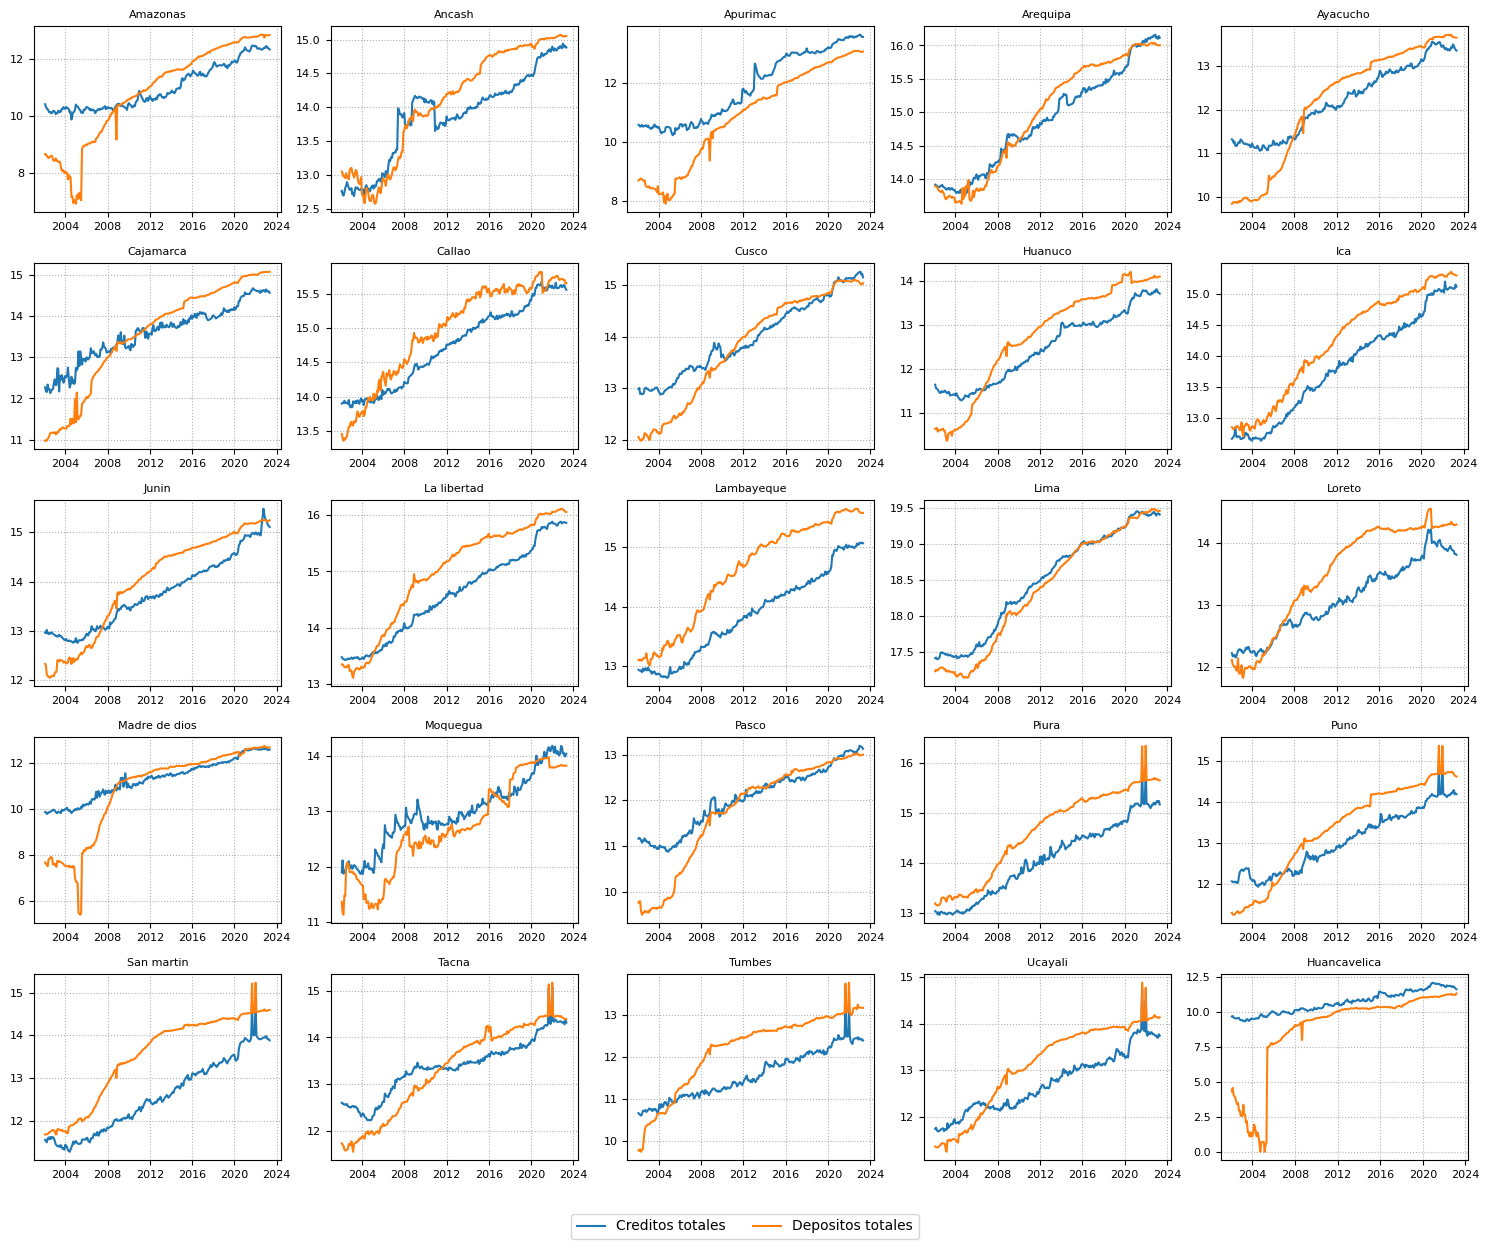

In [ ]:

## Datos a nivel distrital
ft_dep_month = ft_total.groupby(['date', 'departamento']).sum(numeric_only=True).reset_index()


fig,axss = plt.subplots(5,5, figsize=(15,12))
axss = axss.flatten()

for ii,jj in enumerate((ft_dep_month.departamento).unique()):
  print(ii,jj,end='--')
  axi = axss[ii]
  serie = ft_dep_month[ft_dep_month.departamento == jj].set_index('date').iloc[:,1:3]
  serie.index = pd.date_range(start ='2002-01', freq = 'M', periods = len(serie))
  for kk in serie:
    axi.plot(np.log(serie[kk]))
  axi.set_title(jj.capitalize())

  fontsize = 8
  for item in ([axi.title,
                axi.xaxis.label, axi.yaxis.label] +
                axi.get_xticklabels() + axi.get_yticklabels()):
      item.set_fontsize(fontsize)


  axi.xaxis.set_major_locator(mdates.YearLocator(4))  # Set major tick every three years
  axi.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format tick labels as four-digit years
  axi.grid(linestyle=':')

legend = fig.legend(['Creditos totales','Depositos totales'],bbox_to_anchor=(0.5, -0.01), loc='upper center', ncol=2)  # Ajusta los parámetros según tus necesidades

plt.tight_layout()
plt.show()



0 amazonas--1 ancash--2 apurimac--3 arequipa--4 ayacucho--5 cajamarca--6 callao--7 cusco--8 huancavelica--9 huanuco--10 ica--11 junin--12 la libertad--13 lambayeque--14 lima--15 loreto--16 madre de dios--17 moquegua--18 pasco--19 piura--20 puno--21 san martin--22 tacna--23 tumbes--24 ucayali--

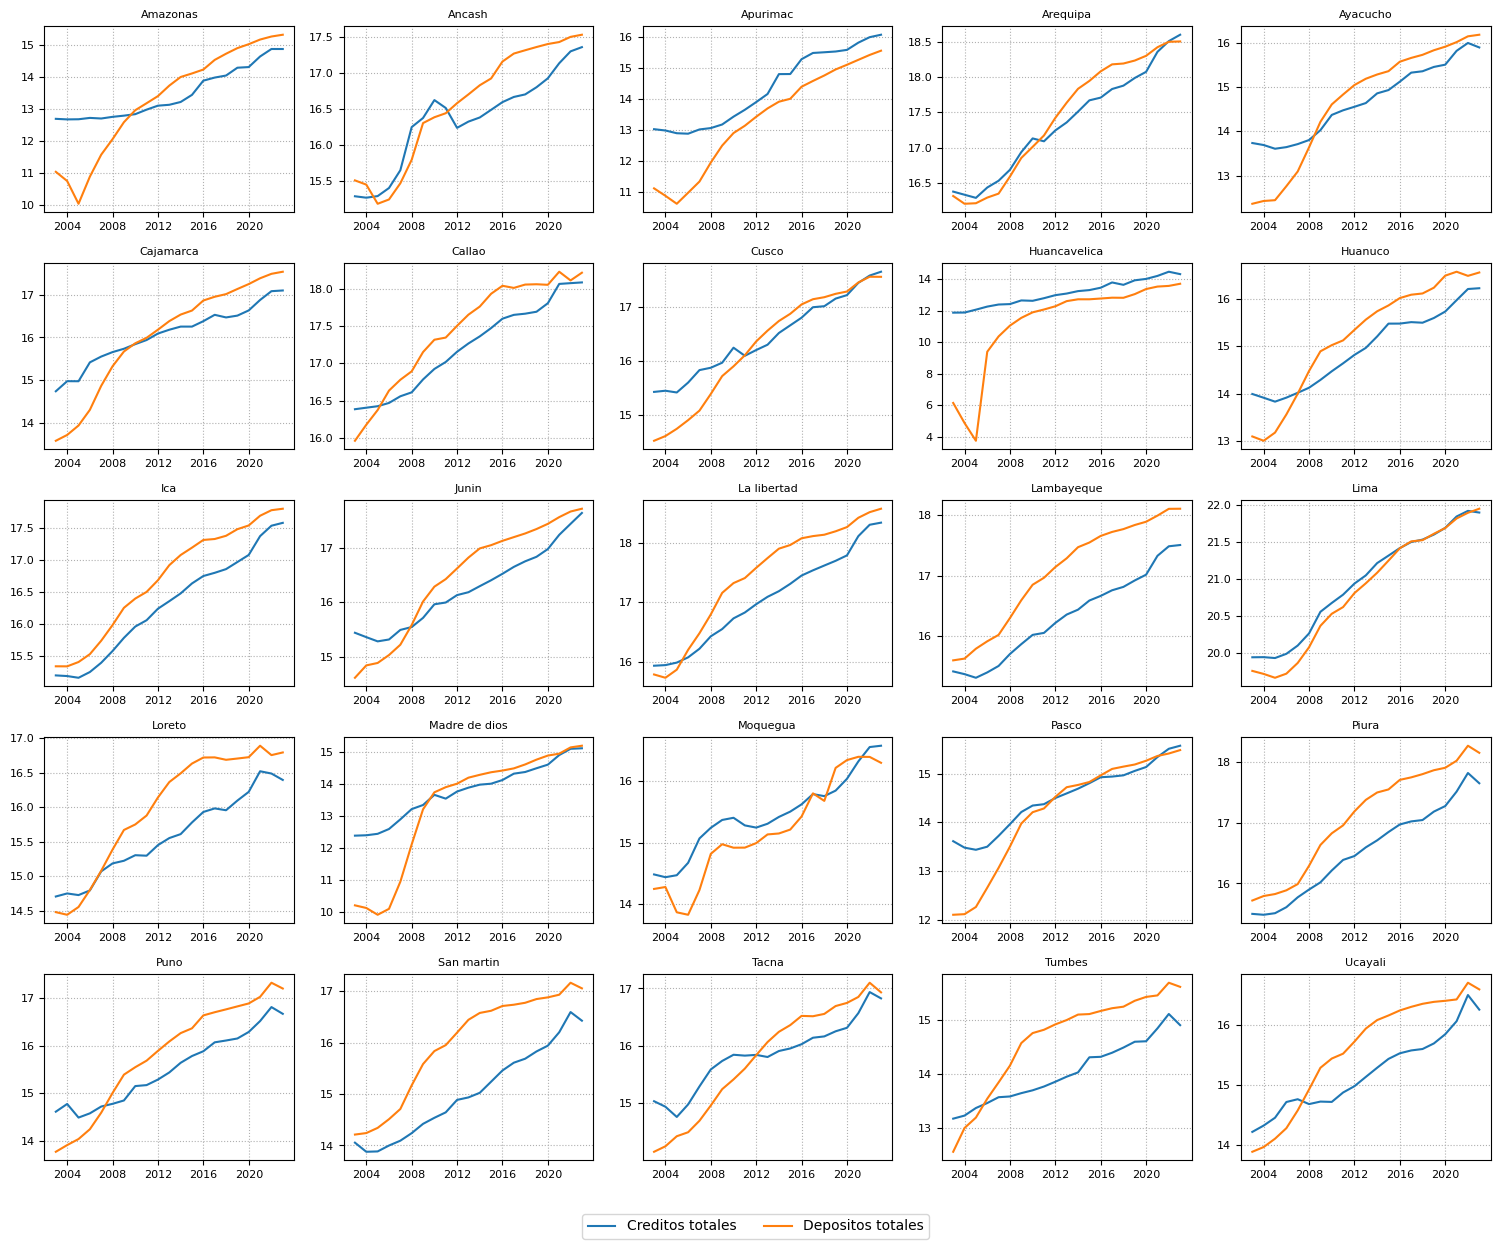

In [ ]:
#para trabajar con el periodo anual, solo trabajamos con los anos completos. Hasta el 2022
ft_dep_year = ft_total[ft_total.year!='2023'].groupby(['year', 'departamento']).sum(numeric_only=True).reset_index()

## no trabajar con year, sino con date.
fig,axss = plt.subplots(5,5, figsize=(15,12))
axss = axss.flatten()

for ii,jj in enumerate((ft_dep_year.departamento).unique()):
  print(ii,jj,end='--')
  axi = axss[ii]
  serie = ft_dep_year[ft_dep_year.departamento == jj].set_index('year').iloc[:,1:3]
  serie.index = pd.date_range(start ='2002-01', freq = 'Y', periods = len(serie))
  for kk in serie:
    axi.plot(np.log(serie[kk]))
  axi.set_title(jj.capitalize())

  fontsize = 8
  for item in ([axi.title,
                axi.xaxis.label, axi.yaxis.label] +
                axi.get_xticklabels() + axi.get_yticklabels()):
      item.set_fontsize(fontsize)


  axi.xaxis.set_major_locator(mdates.YearLocator(4))  # Set major tick every three years
  axi.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format tick labels as four-digit years
  axi.grid(linestyle=':')

legend = fig.legend(['Creditos totales','Depositos totales'],bbox_to_anchor=(0.5, -0.01), loc='upper center', ncol=2)  # Ajusta los parámetros según tus necesidades

plt.tight_layout()
plt.show()

## Modelo de regresion Panel

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import requests
requests.packages.urllib3.disable_warnings()


## EXtraer el PBI por departamentos del INEI

In [ ]:

url_pbi = "https://m.inei.gob.pe/media/MenuRecursivo/indices_tematicos/pbi_peru_2021_1.xlsx"
print(url_pbi)

# Descargar el archivo localmente
response = requests.get(url_pbi, verify=False )
with open("pbi_peru_2021_1.xlsx", "wb") as file:
    file.write(response.content)


excel_file = pd.ExcelFile("pbi_peru_2021_1.xlsx")

# Obtener los nombres de las hojas
sheet_names = excel_file.sheet_names

# Imprimir los nombres de las hojas
print(sheet_names)

# Leer el archivo descargado con Pandas
pbi_dep = pd.read_excel("pbi_peru_2021_1.xlsx", sheet_name='cuadro4', skiprows=6 , \
                        skipfooter=10)

pbi_dep.dropna(how='all', inplace=True)

pbi_dep.columns = ['departamento'] + [str(i) for i in np.arange(2007, 2022)]
 # Continúa con el procesamiento de los datos del archivo Excel

pbi_dep['departamento'] = pbi_dep['departamento'].str.lower().apply(remove_accents)

pbi_dep['departamento'] = pbi_dep['departamento'].str.replace('prov. const. del callao', 'callao') #old, new


pbi_dep = pbi_dep[pbi_dep['departamento'] != 'provincia de lima']

pbi_dep = pbi_dep[pbi_dep['departamento'] != 'region lima']

## Quiero tener un df de 3 columnas: dep,year,pib
pbi_dep_r = pd.melt(pbi_dep, id_vars=['departamento'], var_name='year', value_name='pib')


pbi_dep_r

https://m.inei.gob.pe/media/MenuRecursivo/indices_tematicos/pbi_peru_2021_1.xlsx
['cuadro1', 'cuadro2', 'cuadro3', 'cuadro4', 'cuadro5', 'cuadro6']


<ipython-input-43-ab3b7e9abda5>:29: FutureWarning: The default value of regex will change from True to False in a future version.
  pbi_dep['departamento'] = pbi_dep['departamento'].str.replace('prov. const. del callao', 'callao') #old, new


,departamento,year,pib
0,amazonas,2007,1778775.0
1,ancash,2007,15672771.0
2,apurimac,2007,1824181.0
3,arequipa,2007,16991831.0
4,ayacucho,2007,2975676.0
...,...,...,...
370,puno,2021,17604291.0
371,san martin,2021,9765899.0
372,tacna,2021,12106771.0
373,tumbes,2021,4322879.0


In [ ]:
ft_dep_year

,year,departamento,depositos totales total,creditos directos total
0,2002,amazonas,3.249030e+05,6.224400e+04
1,2002,ancash,4.328413e+06,5.399984e+06
2,2002,apurimac,4.549150e+05,6.793900e+04
3,2002,arequipa,1.290848e+07,1.212434e+07
4,2002,ayacucho,9.248250e+05,2.339930e+05
...,...,...,...,...
520,2022,puno,1.741951e+07,2.969845e+07
521,2022,san martin,1.358130e+07,2.545683e+07
522,2022,tacna,2.033359e+07,2.258484e+07
523,2022,tumbes,2.960553e+06,6.005513e+06


In [ ]:
## banca multiple comprende a los bancos:
## se incluye al bcp, interbank, bbva etc

In [ ]:
#regresion
#usar creditos, pbi ,

# usar modelos panel, y agregar exogenas usadas en la literatura.
# estas exogenas deben der a nivel de departamentos

In [ ]:
final = pd.merge(ft_dep_year, pbi_dep_r, how='left', on=['year','departamento']).dropna()

final['cred_pbi'] = final['creditos directos total'] / final['pib'] * 100
final['dep_pbi'] = final['depositos totales total'] / final['pib'] * 100

In [ ]:
final

,year,departamento,depositos totales total,creditos directos total,pib,cred_pbi,dep_pbi
125,2007,amazonas,3.456845e+05,1.723878e+05,1778775.0,9.691379,19.433853
126,2007,ancash,1.133870e+07,7.193297e+06,15672771.0,45.896780,72.346466
127,2007,apurimac,4.712356e+05,1.557925e+05,1824181.0,8.540408,25.832723
128,2007,arequipa,1.759773e+07,1.597996e+07,16991831.0,94.044948,103.565843
129,2007,ayacucho,9.898547e+05,8.393917e+05,2975676.0,28.208437,33.264870
...,...,...,...,...,...,...,...
495,2021,puno,2.008241e+07,3.355495e+07,17604291.0,190.606662,114.076770
496,2021,san martin,1.605794e+07,2.839332e+07,9765899.0,290.739427,164.428721
497,2021,tacna,2.269578e+07,2.670417e+07,12106771.0,220.572231,187.463564
498,2021,tumbes,3.638788e+06,6.479262e+06,4322879.0,149.883023,84.175109


0 amazonas--1 ancash--2 apurimac--3 arequipa--4 ayacucho--5 cajamarca--6 callao--7 cusco--8 huancavelica--9 huanuco--10 ica--11 junin--12 la libertad--13 lambayeque--14 lima--15 loreto--16 madre de dios--17 moquegua--18 pasco--19 piura--20 puno--21 san martin--22 tacna--23 tumbes--24 ucayali--

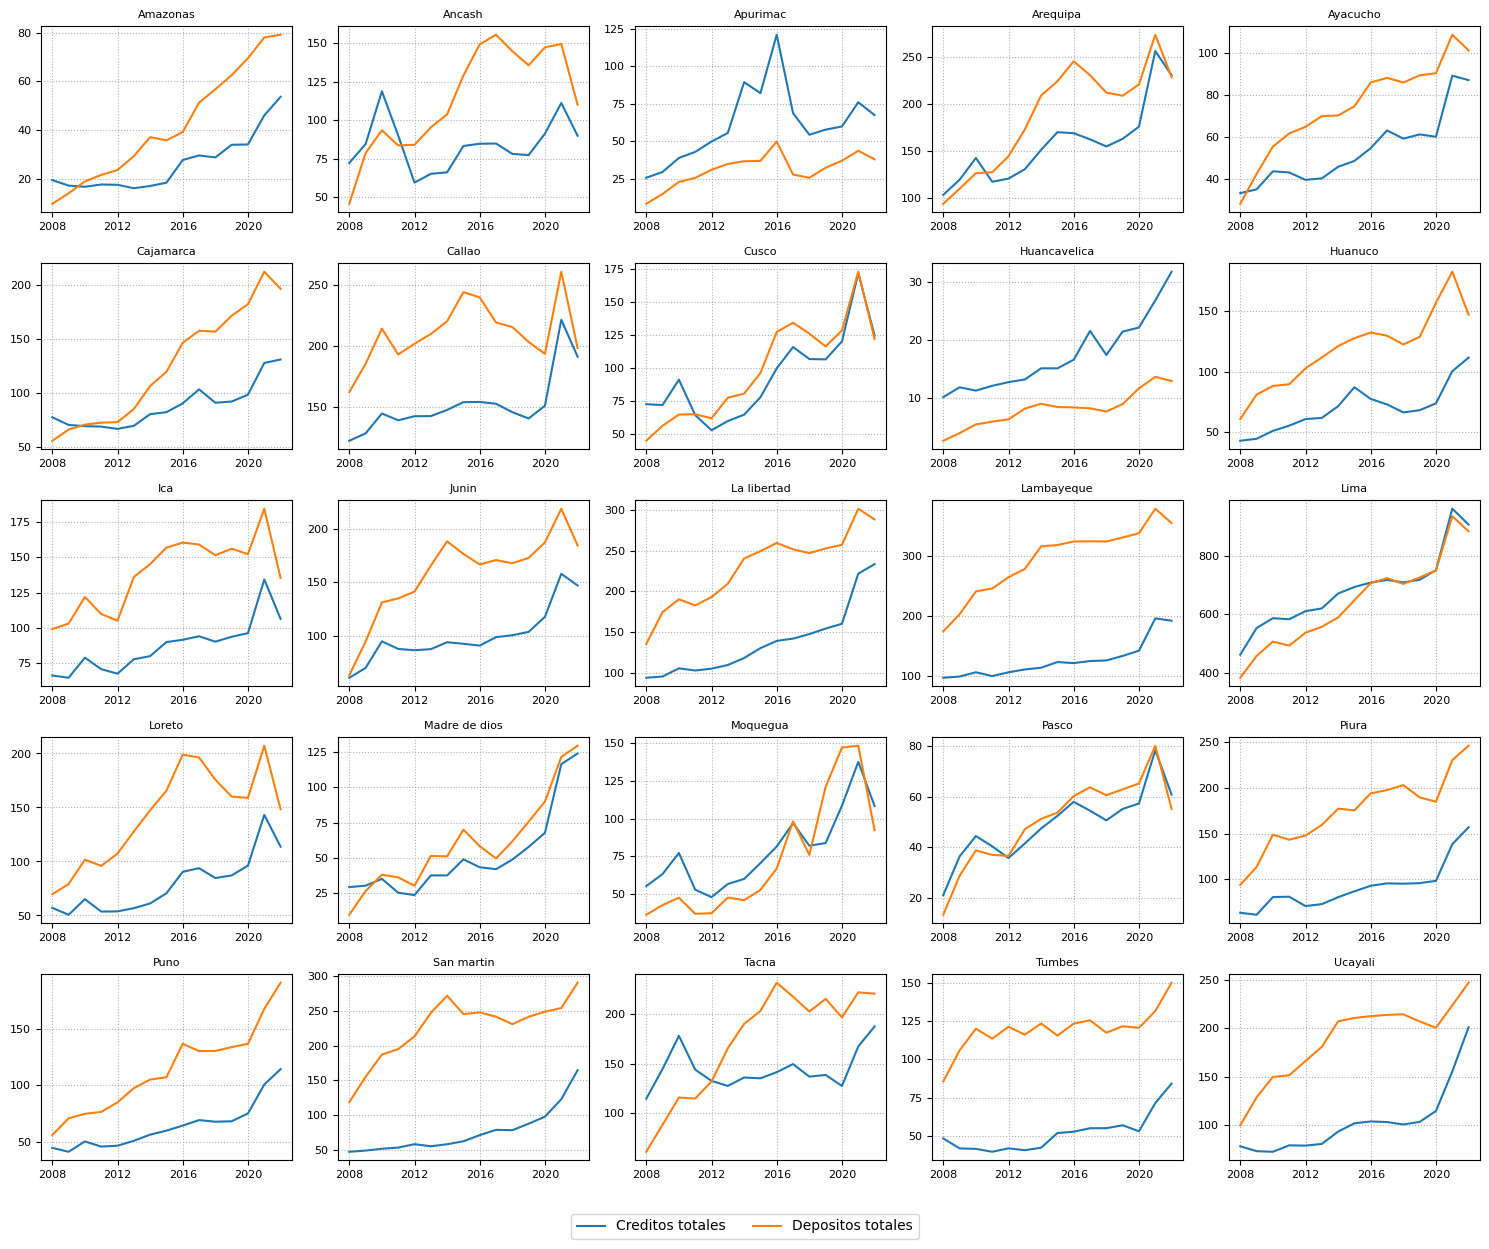

In [ ]:


fig,axss = plt.subplots(5,5, figsize=(15,12))
axss = axss.flatten()

for ii,jj in enumerate((final.departamento).unique()):
  print(ii,jj,end='--')
  axi = axss[ii]
  serie = final[final.departamento == jj].set_index('year')
  serie = serie[['dep_pbi','cred_pbi']]
  serie.index = pd.date_range(start ='2007-01', freq = 'Y', periods = len(serie))

  for kk in serie:
    axi.plot(serie[kk])
  axi.set_title(jj.capitalize())

  fontsize = 8
  for item in ([axi.title,
                axi.xaxis.label, axi.yaxis.label] +
                axi.get_xticklabels() + axi.get_yticklabels()):
      item.set_fontsize(fontsize)


  axi.xaxis.set_major_locator(mdates.YearLocator(4))  # Set major tick every three years
  axi.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format tick labels as four-digit years
  axi.grid(linestyle=':')

legend = fig.legend(['Creditos totales','Depositos totales'],bbox_to_anchor=(0.5, -0.01), loc='upper center', ncol=2)  # Ajusta los parámetros según tus necesidades

plt.tight_layout()
plt.show()

In [ ]:
final

,year,departamento,depositos totales total,creditos directos total,pib,cred_pbi,dep_pbi
125,2007,amazonas,3.456845e+05,1.723878e+05,1778775.0,9.691379,19.433853
126,2007,ancash,1.133870e+07,7.193297e+06,15672771.0,45.896780,72.346466
127,2007,apurimac,4.712356e+05,1.557925e+05,1824181.0,8.540408,25.832723
128,2007,arequipa,1.759773e+07,1.597996e+07,16991831.0,94.044948,103.565843
129,2007,ayacucho,9.898547e+05,8.393917e+05,2975676.0,28.208437,33.264870
...,...,...,...,...,...,...,...
495,2021,puno,2.008241e+07,3.355495e+07,17604291.0,190.606662,114.076770
496,2021,san martin,1.605794e+07,2.839332e+07,9765899.0,290.739427,164.428721
497,2021,tacna,2.269578e+07,2.670417e+07,12106771.0,220.572231,187.463564
498,2021,tumbes,3.638788e+06,6.479262e+06,4322879.0,149.883023,84.175109


## Ejecucion de la regresion panel

In [ ]:
pip install linearmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.5/82.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from linearmodels.panel import PanelOLS
from linearmodels.panel import compare

In [ ]:
reg = final.copy()
reg['year'] = pd.to_numeric(reg['year'])  # Convierte 'year' a tipo numérico
reg.head()


,year,departamento,depositos totales total,creditos directos total,pib,cred_pbi,dep_pbi
125,2007,amazonas,3.456845e+05,1.723878e+05,1778775.0,9.691379,19.433853
126,2007,ancash,1.133870e+07,7.193297e+06,15672771.0,45.896780,72.346466
127,2007,apurimac,4.712356e+05,1.557925e+05,1824181.0,8.540408,25.832723
128,2007,arequipa,1.759773e+07,1.597996e+07,16991831.0,94.044948,103.565843
129,2007,ayacucho,9.898547e+05,8.393917e+05,2975676.0,28.208437,33.264870


In [ ]:

# Paso 3: Crea el índice del panel
reg = reg.set_index(['departamento', 'year'])
reg

,,depositos totales total,creditos directos total,pib,cred_pbi,dep_pbi
departamento,year,,,,,
amazonas,2007,3.456845e+05,1.723878e+05,1778775.0,9.691379,19.433853
ancash,2007,1.133870e+07,7.193297e+06,15672771.0,45.896780,72.346466
apurimac,2007,4.712356e+05,1.557925e+05,1824181.0,8.540408,25.832723
arequipa,2007,1.759773e+07,1.597996e+07,16991831.0,94.044948,103.565843
ayacucho,2007,9.898547e+05,8.393917e+05,2975676.0,28.208437,33.264870
...,...,...,...,...,...,...
puno,2021,2.008241e+07,3.355495e+07,17604291.0,190.606662,114.076770
san martin,2021,1.605794e+07,2.839332e+07,9765899.0,290.739427,164.428721
tacna,2021,2.269578e+07,2.670417e+07,12106771.0,220.572231,187.463564


In [ ]:

# Paso 4: Define las variables dependientes e independientes
y = reg['pib']  # Variable dependiente
X = reg[['depositos totales total', 'creditos directos total']]  # Variables independientes

# Paso 5: Agrega una constante a la matriz de variables independientes
X = sm.add_constant(X)


# Paso 5: Crea el objeto de regresión de panel
model = PanelOLS(y, X, entity_effects = True, time_effects=True)

# Paso 6: Ajusta el modelo
results = model.fit()

# Paso 7: Imprime los resultados
print(results)



                          PanelOLS Estimation Summary                           
Dep. Variable:                    pib   R-squared:                        0.9309
Estimator:                   PanelOLS   R-squared (Between):              0.7350
No. Observations:                 375   R-squared (Within):               0.9129
Date:                Tue, Jun 27 2023   R-squared (Overall):              0.7511
Time:                        14:46:51   Log-likelihood                   -6198.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2251.0
Entities:                          25   P-value                           0.0000
Avg Obs:                       15.000   Distribution:                   F(2,334)
Min Obs:                       15.000                                           
Max Obs:                       15.000   F-statistic (robust):             2251.0
                            

In [ ]:
model_fe = PanelOLS(y, X, entity_effects=True, time_effects=True)
model_re = PanelOLS(y, X, entity_effects=False, time_effects=False)


In [ ]:
# Paso 6: Ajusta los modelos
results_fe = model_fe.fit()
results_re = model_re.fit()
# Paso 7: Crea una tabla de resultados comparativos
results_table = compare({'Efectos Fijos': results_fe, 'Efectos Aleatorios': results_re})
results_table

,Efectos Fijos,Efectos Aleatorios
Dep. Variable,pib,pib
Estimator,PanelOLS,PanelOLS
No. Observations,375,375
Cov. Est.,Unadjusted,Unadjusted
R-squared,0.9309,0.9575
R-Squared (Within),0.9129,0.7498
R-Squared (Between),0.7350,0.9781
R-Squared (Overall),0.7511,0.9575
F-statistic,2251.0,4190.3
P-value (F-stat),0.0000,0.0000


In [ ]:
from scipy import stats

In [ ]:
# Paso 5: Crea los objetos de regresión de panel para efectos fijos y efectos aleatorios
model_fe = PanelOLS(y, X, entity_effects=True, time_effects=True)
model_re = PanelOLS(y, X, entity_effects=False, time_effects=False)

# Paso 6: Ajusta los modelos
results_fe = model_fe.fit()
results_re = model_re.fit()

# Paso 7: Calcula la prueba de Hausman manualmente
cov_fe = results_fe.cov
cov_re = results_re.cov
b_fe = results_fe.params
b_re = results_re.params
delta_b = b_fe - b_re
var_delta_b = cov_fe - cov_re
var_delta_b_inv = np.linalg.inv(var_delta_b)
hausman_stat = delta_b.T @ var_delta_b_inv @ delta_b
p_value = 1 - stats.chi2.cdf(hausman_stat, df=delta_b.shape[0])

# Paso 8: Imprime el resultado de la prueba de Hausman
print("Estadístico de Hausman:", hausman_stat)
print("Valor p de la prueba de Hausman:", p_value)

# Paso 9: Elige entre efectos fijos y efectos aleatorios según el resultado de la prueba de Hausman
if p_value < 0.05:
    print("Se rechaza la hipótesis nula de la prueba de Hausman.")
    print("Los efectos fijos son más apropiados.")
else:
    print("No se rechaza la hipótesis nula de la prueba de Hausman.")
    print("Los efectos aleatorios son más apropiados.")


Estadístico de Hausman: 1410.5664178648658
Valor p de la prueba de Hausman: 0.0
Se rechaza la hipótesis nula de la prueba de Hausman.
Los efectos fijos son más apropiados.
